# 임베딩 내 편향성 알아보기

## 필요한 라이브러리

In [1]:
import konlpy
import gensim
import sklearn
import seaborn


## WEAT 구현

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [3]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

In [4]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

## 전체 시놉시스로 임베딩 모델 만들기

In [5]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

def read_token(file_name, mode='tfidf'):
    """
    mode:
        - 'tfidf' → 전체 문서를 하나의 줄글(str)로 반환 (TF-IDF용)
        - 'w2v'   → 문장별로 리스트(List[List[str]]) 반환 (Word2Vec용)
    """
    okt = Okt()
    result = []
    file_path = os.path.join(os.getenv('HOME'), 'aiffel', 'weat', file_name)
    
    with open(file_path, 'r', encoding='utf-8') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        for line in fread:
            line = line.strip()
            if not line:
                continue
            tokenlist = okt.pos(line, stem=True, norm=True)
            tokens = [word for word, tag in tokenlist if tag == 'Noun']
            if mode == 'w2v':
                if tokens:
                    result.append(tokens)  # 문장 단위 리스트
            else:  # mode == 'tfidf'
                result.extend(tokens)  # 하나의 긴 리스트

    if mode == 'tfidf':
        return ' '.join(result)
    return result

In [6]:
total = 'synopsis.txt'
tokens = read_token(total, 'w2v')

synopsis.txt 파일을 읽고 있습니다.


In [7]:
print(len(tokens))

70683


In [8]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다.
model = Word2Vec(tokens, vector_size=100, window=5, min_count=3, sg=0)  

In [9]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.711112916469574),
 ('진심', 0.7056841254234314),
 ('애정', 0.6983410120010376),
 ('윌링턴', 0.69765305519104),
 ('만남', 0.6916741728782654),
 ('행복', 0.6878758668899536),
 ('가슴', 0.6814060211181641),
 ('이별', 0.6775075793266296),
 ('운명', 0.6762726902961731),
 ('연애', 0.6756232380867004)]

## target 데이터 추출

In [10]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [12]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

### 단어 추출 1. 상위 15개 뽑기
겹치는 단어가 너무 많아 사용하지 않겠다.

In [13]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

### 단어 추출 2. 겹치지 않게 상위 15개 뽑기

In [14]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art_1, target_gen_1 = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art_1.append(w1_[i])
    if len(target_art_1) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen_1.append(w2_[i])
    if len(target_gen_1) == n: break

In [15]:
print(target_art_1)
print(target_gen_1)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## attribute 데이터 추출

In [16]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [17]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

### 단어 추출 1. 상위 15개 뽑기

In [19]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

In [20]:
print(len(w))

21


In [21]:
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes_1 = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes_1.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

In [23]:
from collections import Counter

# 1. 전체 단어 평탄화
all_words = [word for attr in attributes_1 for word in attr]

# 2. 중복 단어 수 확인
counter = Counter(all_words)
duplicates = [word for word, cnt in counter.items() if cnt > 3]
num_duplicates = sum(counter[word] - 1 for word in duplicates)

# 3. 전체 단어 수
total_words = len(all_words)

# 4. 겹치는 비율 계산
dup_ratio = num_duplicates / total_words
print(f'🔁 겹치는 단어 수: {num_duplicates} / 전체 단어 수: {total_words}')
print(f'📊 겹치는 비율: {dup_ratio:.3f}')

🔁 겹치는 단어 수: 156 / 전체 단어 수: 315
📊 겹치는 비율: 0.495


### 단어 추출 2. 겹치지 않게 상위 15개 뽑기
TF-IDF 상위 후보 단어를 200까지 늘려도 단어 개수가 너무 적은 문서 존재

In [22]:
from collections import Counter

n = 15  # 장르당 추출할 단어 수
max_dup = 1  # 최대 허용 등장 횟수

# 1. TF-IDF 상위 후보 단어 수집 (최대 200개씩)
print("candidate 계산")
print(len(w))
candidate_lists = []
for i in range(len(w)):
    print(i)
    sorted_terms = sorted(w[i], key=lambda x: x[1], reverse=True)
    words = [
        vectorizer.get_feature_names()[idx]
        for idx, _ in sorted_terms[:200]
        if vectorizer.get_feature_names()[idx] in model.wv
    ]
    candidate_lists.append(words)

# 2. 전체 단어 등장 횟수 계산
print("단어 횟수 계산")
flat_words = [word for lst in candidate_lists for word in lst]
word_counts = Counter(flat_words)

# 3. 중복 단어 제외하고 최대 15개씩 추출
print("중복 단어 제외")
attributes_2 = []
for i in range(len(candidate_lists)):
    print(genre_name[i], end=': ')
    attr = []
    for word in candidate_lists[i]:
        if word_counts[word] <= max_dup:
            attr.append(word)
        if len(attr) == n:
            break
    attributes_2.append(attr)
    print(', '.join(attr))


candidate 계산
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
단어 횟수 계산
중복 단어 제외
SF: 외계, 시스템, 스타크, 리플리, 켈빈, 컨트, 수퍼맨, 외계인, 분파, 상어, 물체, 진화, 수트, 히노키, 섹터
가족: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 최호, 혜지, 유나, 테리, 손녀
공연: 실황, 올레, 오텔로, 리골레토, 백작, 프레, 베르디, 비바, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다
공포(호러): 악령, 귀신, 사라, 기운, 치료, 분홍신, 건물, 신부, 의식, 늑대인간, 캠핑, 정신병원, 집안, 레드, 생존자
기타: 뉴미디어, 아시아나, 상영작, 지하철, 유럽, 메트로, 실험영화, 대화, 광주, 프라이드, 비디오, 반복, 디지털, 공사, 장애인
다큐멘터리: 투쟁, 인디다큐페스티발, 문화, 건축, 인터뷰, 운동, 지난, 당시, 목소리, 등반, 활동, 정치, 인권영화제, 건축사, 세대
드라마: 가정, 갈등, 부모
멜로로맨스: 커플, 동거, 첫사랑, 형부, 위로, 미연, 펜션, 옆집, 수진, 하숙집, 주희, 준석, 하룻밤, 이별, 재혼
뮤지컬: 뮤지컬, 에스메랄다, 충무로, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 팬텀, 크리스틴, 노트르담, 라훌
미스터리: 민혁, 방독면, 랭던, 몰카, 거미숲, 사이먼, 수연, 홈즈, 종섭, 한나, 연쇄살인범, 상우, 주장, 승호, 동식
범죄: 한길수, 파푸아, 금고, 테러범, 마샨, 검사, 철중, 도미, 사기꾼, 범행, 불법, 체포, 맥베드, 와처스, 샤오창
사극: 조선, 신기전, 아가멤논, 루안, 하선, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력, 양반
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 랜던
성인물(에로): 유이, 욕구불만, 성관

### 단어 추출 3. 4번 이상 나오는 단어는 제외하기

In [23]:
from collections import Counter

n = 15  # 장르당 추출할 단어 수
max_dup = 3  # 최대 허용 등장 횟수

# 1. TF-IDF 상위 후보 단어 수집 (최대 100개씩)
print("candidate 계산")
print(len(w))
candidate_lists = []
for i in range(len(w)):
    print(i)
    sorted_terms = sorted(w[i], key=lambda x: x[1], reverse=True)
    words = [
        vectorizer.get_feature_names()[idx]
        for idx, _ in sorted_terms[:100]
        if vectorizer.get_feature_names()[idx] in model.wv
    ]
    candidate_lists.append(words)

# 2. 전체 단어 등장 횟수 계산
print("단어 횟수 계산")
flat_words = [word for lst in candidate_lists for word in lst]
word_counts = Counter(flat_words)

# 3. 중복 단어 제외하고 최대 15개씩 추출
print("중복 단어 제외")
attributes_3 = []
for i in range(len(candidate_lists)):
    print(genre_name[i], end=': ')
    attr = []
    for word in candidate_lists[i]:
        if word_counts[word] <= max_dup:
            attr.append(word)
        if len(attr) == n:
            break
    attributes_3.append(attr)
    print(', '.join(attr))


candidate 계산
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
단어 횟수 계산
중복 단어 제외
SF: 인류, 미래, 우주, 로봇, 박사, 우주선, 외계, 행성, 실험, 능력, 시스템, 생명체, 정부, 스타크, 리플리
가족: 아주르, 낙타, 씨제이, 동구, 슈이트, 어머니, 마갈, 미아, 펠리칸, 벤트, 케이시, 할아버지, 엠마, 고양이, 크리스마스
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트
공포(호러): 공포, 악령, 좀비, 저주, 이후, 일행, 악몽, 병원, 파티, 유령, 귀신, 악마, 저택, 바이러스, 이사
기타: 뉴미디어, 페스티벌, 독립, 아시아나, 연출, 이미지, 부산, 상영작, 지하철, 청소년, 유럽, 노인, 의도, 판타스틱, 공간
다큐멘터리: 다큐, 다큐멘터리, 한국, 환경, 사회, 노동자, 기록, 역사, 카메라, 과정, 지역, 투쟁, 인디다큐페스티발, 일상, 문제
드라마: 부문, 연출, 어머니, 독립, 인생, 부산, 일상, 의도, 감정, 한국, 경쟁, 상처, 사회, 처음, 시절
멜로로맨스: 섹스, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 유부녀, 감정, 정사, 출장, 선배, 여자친구, 커플, 만난
뮤지컬: 뮤지컬, 에스메랄다, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 데이비
미스터리: 진실, 민혁, 미스터리, 현우, 방독면, 소설, 용의자, 공포, 여인, 추적, 의심, 사진, 조사, 이후, 랭던
범죄: 범죄, 마약, 한길수, 은행, 작전, 보스, 마피아, 용의자, 추적, 프랭크, 조사, 감옥, 현장, 파푸아, 금고
사극: 조선, 신기전, 아가멤논, 황제, 루안, 하선, 윤서, 트로이, 세자, 허균, 노준, 채선, 신재효, 히파티아, 권력
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 무법자, 프린트, 마적

### 단어 추출 4. LSA 활용

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_topics = 100  # 충분히 큰 값 설정
svd = TruncatedSVD(n_components=n_topics, random_state=42)
X_lsa = svd.fit_transform(X)  # shape: (21, 100)
topic_word_matrix = svd.components_  # shape: (100, vocab_size)

In [ ]:
import numpy as np

# 각 문서에서 중요도가 높은 5개 토픽 인덱스 선택
doc_top_topics = np.argsort(X_lsa, axis=1)[:, -5:]
print(doc_top_topics)

In [ ]:
# Flatten 후 등장 횟수 계산
topic_counts = Counter(doc_top_topics.flatten())

# 5번 이상 등장한 토픽 set
excluded_topics = {topic for topic, count in topic_counts.items() if count >= 5}

print(excluded_topics)

In [ ]:
def select_valid_topics_for_doc(doc_topic_scores, excluded_set, top_k=5):
    # doc_topic_scores: shape (100,), 토픽 중요도
    sorted_indices = np.argsort(doc_topic_scores)[::-1]
    filtered = [i for i in sorted_indices if i not in excluded_set]
    return filtered[:top_k]

final_doc_topics = [
    select_valid_topics_for_doc(X_lsa[i], excluded_topics)
    for i in range(21)
]

print(final_doc_topics)

In [ ]:
terms = vectorizer.get_feature_names_out()

def get_top_words_for_topic(topic_idx, top_k):
    word_scores = topic_word_matrix[topic_idx]
    top_word_indices = np.argsort(word_scores)[::-1][:top_k]
    return [terms[i] for i in top_word_indices]

# 각 문서에 대해 대표 단어 15개씩 추출
doc_keywords = []
word_count_per_rank = [5, 4, 3, 2, 1]  # 순위별 추출 단어 수

for doc_topics in final_doc_topics:
    words = []
    for rank, topic in enumerate(doc_topics[:5]):
        count = word_count_per_rank[rank]
        words.extend(get_top_words_for_topic(topic, top_k=count))
    doc_keywords.append(words)  # 총 15개 단어

In [ ]:
for i, keywords in enumerate(doc_keywords):
    print(f"{genre_name[i]} 대표 단어 15개:")
    print(", ".join(keywords))
    print("-" * 50)

## 편향성 계산

- target은 art, gen
- attribute는 21가지 장르
- target은 중복 없앤 TF-IDF 기반 대표 단어 15개
- attribute는 총 3가지
    - 중복 허용 TF-IDF 대표단어 15개
    - 중복 3개까지 허용 TF-IDF 대표단어 15개
    - LSA 기반 각 문서별 5개의 관련 토픽 이용한 대표 단어 15개

### WEAT matrix 계산 함수

In [ ]:
X = np.array([model.wv[word] for word in target_art_1])
Y = np.array([model.wv[word] for word in target_gen_1])

def weat_matrix(attributes):
    matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
    for i in range(len(genre_name)-1):
        for j in range(i+1, len(genre_name)):
            A = np.array([model.wv[word] for word in attributes[i]])
            B = np.array([model.wv[word] for word in attributes[j]])
            matrix[i][j] = weat_score(X, Y, A, B)
    for i in range(len(genre_name)-1):
        for j in range(i+1, len(genre_name)):
            print(genre_name[i], genre_name[j],matrix[i][j])
    return matrix

### 1. 중복 허용 TF-IDF 기반 attribute

In [ ]:
matrix_1 = weat_matrix(attributes_1)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 폰트 설정
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 플롯 크기 설정
plt.figure(figsize=(12, 10))  # 원하는 크기로 조절 (가로, 세로)

# heatmap 그리기 (소수점 둘째 자리까지 표시)
ax = sns.heatmap(
    matrix_1,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    fmt=".2f",  # 소수점 둘째 자리 반올림
    cmap='RdYlGn_r'
)

plt.tight_layout()
plt.show()

- 다큐멘터리가 상업 영화로 치우쳐 있고, 멜로로멘스가 예술 영화로 치우쳐 있다.
    - 개인적으로 완전히 반대되어야 맞다고 생각한다.
- 공포, 미스터리, 스릴러 장르가 예술 영화의 경향을 보이고, SF, 뮤지컬, 전쟁 장르가 산업 영화의 경향을 보인다.
    - 공포 장르와 뮤지컬 장르는 적절하지 않다고 생각한다.

In [ ]:
print("=== WEAT 점수 | 절댓값 기준 0.8 이상만 출력 ===")
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        score = matrix_1[i][j]
        if abs(score) >= 0.8:
            print(f"{genre_name[i]} vs {genre_name[j]}: {score:.3f}")

- 위에서 확인했던 바와 같이 다큐멘터리가 상업 영화와 관련이 높고, 멜로로멘스가 예술 영화와 관련이 높다.
- 애니메이션 장르가 산업 영화와 관련이 높다.
    - 아이들을 타깃으로 한 애니메이션 영화는 산업 영화의 경향이 높으므로 타당하다.
- 기타로 분류된 영화들이 산업 영화와 관련이 높다.
- 사극 장르가 예술 영화와 관련이 높다.
    - 사극은 보통 예술 영화와 산업 영화의 경계에 있다고 생각하여 예술 영화로 치우치는 것은 타당하지 않다고 생각한다.

In [ ]:
from sklearn.decomposition import PCA

def draw_pca(doc_keywords):
    # === 1. 전체 단어 집합 구성 ===
    unique_words = set(word for doc in doc_keywords for word in doc)
    unique_words |= set(target_art_1)
    unique_words |= set(target_gen_1)

    # === 2. Word2Vec에 존재하는 단어 필터링 ===
    filtered_words = [word for word in unique_words if word in model.wv]
    if len(filtered_words) < 2:
        print("⚠️ PCA를 수행할 단어가 부족합니다.")
        return

    # === 3. 장르별 평균 벡터 계산 ===
    genre_avg_vecs = []
    genre_labels = []
    for doc_words, genre in zip(doc_keywords, genre_name):
        vecs = [model.wv[word] for word in doc_words if word in model.wv]
        if len(vecs) == 0:
            continue
        avg_vec = np.mean(vecs, axis=0)
        genre_avg_vecs.append(avg_vec)
        genre_labels.append(genre)

    # === 4. target 단어 벡터 ===
    art_vecs = [model.wv[word] for word in target_art_1 if word in model.wv]
    gen_vecs = [model.wv[word] for word in target_gen_1 if word in model.wv]

    # === 5. PCA 수행 ===
    all_vecs = genre_avg_vecs + art_vecs + gen_vecs
    pca = PCA(n_components=2)
    vecs_2d = pca.fit_transform(all_vecs)

    genre_coords = vecs_2d[:len(genre_avg_vecs)]
    art_coords = vecs_2d[len(genre_avg_vecs):len(genre_avg_vecs)+len(art_vecs)]
    gen_coords = vecs_2d[len(genre_avg_vecs)+len(art_vecs):]

    # === 6. 시각화 ===
    plt.figure(figsize=(13, 11))
    colors = sns.color_palette("tab20", len(genre_coords))

    # (1) 장르별 평균 벡터
    for i, (coord, label) in enumerate(zip(genre_coords, genre_labels)):
        plt.scatter(coord[0], coord[1], label=label, color=colors[i], s=100, edgecolor='k')
        plt.text(coord[0]+0.1, coord[1]+0.1, label, fontsize=9)

    # (2) 예술 영화 단어 (빨간색, +)
    if len(art_coords) > 0:
        plt.scatter(art_coords[:, 0], art_coords[:, 1], c='red', marker='P', s=80, label='예술 영화 단어')

    # (3) 상업 영화 단어 (파란색, ◆)
    if len(gen_coords) > 0:
        plt.scatter(gen_coords[:, 0], gen_coords[:, 1], c='blue', marker='D', s=80, label='상업 영화 단어')

    plt.title("장르별 대표 단어 평균 + 예술/상업 단어의 PCA 시각화")
    plt.legend(
        bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=9
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()


draw_pca(attributes_1)

PCA 그래프에서는 각 장르와 예술/상업 단어의 연관성을 파악하기 어려웠다.

### 2. 3개까지 중복 허용 TF-IDF 기반 attribute

In [135]:
matrix_2 = weat_matrix(attributes_3)

SF 가족 -1.0074438
SF 공연 -0.4307769
SF 공포(호러) -1.0106411
SF 기타 0.3114644
SF 다큐멘터리 0.32297832
SF 드라마 -0.2689912
SF 멜로로맨스 -0.81169575
SF 뮤지컬 -0.13911998
SF 미스터리 -0.8140927
SF 범죄 -0.43994108
SF 사극 -0.4014845
SF 서부극(웨스턴) -0.8780245
SF 성인물(에로) -0.6472716
SF 스릴러 -0.75319135
SF 애니메이션 -0.029878441
SF 액션 -0.38963798
SF 어드벤처 -0.9290681
SF 전쟁 -0.20975798
SF 코미디 -0.77895474
SF 판타지 -0.9671702
가족 공연 0.7403542
가족 공포(호러) 0.15730599
가족 기타 1.0059427
가족 다큐멘터리 0.93486744
가족 드라마 0.82947177
가족 멜로로맨스 -0.24613507
가족 뮤지컬 0.92768
가족 미스터리 0.48070315
가족 범죄 0.8144623
가족 사극 1.062417
가족 서부극(웨스턴) 0.89312875
가족 성인물(에로) 0.19171377
가족 스릴러 0.3586999
가족 애니메이션 0.94082963
가족 액션 0.8769309
가족 어드벤처 0.78055173
가족 전쟁 0.9487956
가족 코미디 0.22191007
가족 판타지 0.74497575
공연 공포(호러) -0.5181175
공연 기타 1.0081205
공연 다큐멘터리 0.68025887
공연 드라마 0.25054458
공연 멜로로맨스 -0.69628745
공연 뮤지컬 1.1465715
공연 미스터리 -0.30401552
공연 범죄 0.015477388
공연 사극 0.4274192
공연 서부극(웨스턴) -0.34216532
공연 성인물(에로) -0.47495148
공연 스릴러 -0.31144837
공연 애니메이션 0.8475367
공연 액션 0.16368768
공연 어

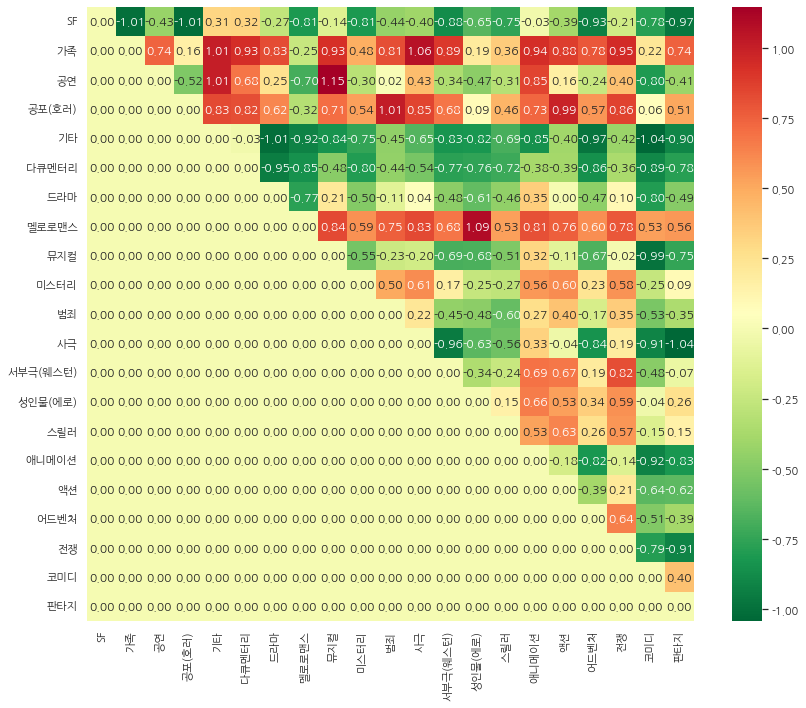

In [136]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 폰트 설정
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 플롯 크기 설정
plt.figure(figsize=(12, 10))  # 원하는 크기로 조절 (가로, 세로)

# heatmap 그리기 (소수점 둘째 자리까지 표시)
ax = sns.heatmap(
    matrix_2,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    fmt=".2f",  # 소수점 둘째 자리 반올림
    cmap='RdYlGn_r'
)

plt.tight_layout()
plt.show()

- 중복 제거 전 분석과 대체로 비슷한 분포를 보였다.
- 가족 장르와 판타지 장르, 코미디 장르가 예술 영화와 관련이 깊어졌다.
    - 세 장르 모두 예술 영화와 큰 연관이 있지 않다고 생각한다.
- 미스터리 장르의 편향성이 감소했다.
    - 미스터리 장르는 상업 영화도 많다고 생각하여 편향성이 감소되는 것이 옳은 방향이라 생각한다.

In [137]:
print("=== WEAT 점수 | 절댓값 기준 0.8 이상만 출력 ===")
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        score = matrix_2[i][j]
        if abs(score) >= 0.8:
            print(f"{genre_name[i]} vs {genre_name[j]}: {score:.3f}")

=== WEAT 점수 | 절댓값 기준 0.8 이상만 출력 ===
SF vs 가족: -1.007
SF vs 공포(호러): -1.011
SF vs 멜로로맨스: -0.812
SF vs 미스터리: -0.814
SF vs 서부극(웨스턴): -0.878
SF vs 어드벤처: -0.929
SF vs 판타지: -0.967
가족 vs 기타: 1.006
가족 vs 다큐멘터리: 0.935
가족 vs 드라마: 0.829
가족 vs 뮤지컬: 0.928
가족 vs 범죄: 0.814
가족 vs 사극: 1.062
가족 vs 서부극(웨스턴): 0.893
가족 vs 애니메이션: 0.941
가족 vs 액션: 0.877
가족 vs 전쟁: 0.949
공연 vs 기타: 1.008
공연 vs 뮤지컬: 1.147
공연 vs 애니메이션: 0.848
공연 vs 코미디: -0.805
공포(호러) vs 기타: 0.831
공포(호러) vs 다큐멘터리: 0.819
공포(호러) vs 범죄: 1.010
공포(호러) vs 사극: 0.853
공포(호러) vs 액션: 0.990
공포(호러) vs 전쟁: 0.862
기타 vs 드라마: -1.014
기타 vs 멜로로맨스: -0.919
기타 vs 뮤지컬: -0.841
기타 vs 서부극(웨스턴): -0.835
기타 vs 성인물(에로): -0.823
기타 vs 애니메이션: -0.852
기타 vs 어드벤처: -0.974
기타 vs 코미디: -1.041
기타 vs 판타지: -0.902
다큐멘터리 vs 드라마: -0.946
다큐멘터리 vs 멜로로맨스: -0.853
다큐멘터리 vs 어드벤처: -0.860
다큐멘터리 vs 코미디: -0.890
멜로로맨스 vs 뮤지컬: 0.839
멜로로맨스 vs 사극: 0.835
멜로로맨스 vs 성인물(에로): 1.089
멜로로맨스 vs 애니메이션: 0.810
뮤지컬 vs 코미디: -0.990
사극 vs 서부극(웨스턴): -0.956
사극 vs 어드벤처: -0.842
사극 vs 코미디: -0.912
사극 vs 판타지: -1.042
서부극(웨스턴) vs 전쟁:

- 중복단어 제거 전과 비교했을 때 편향성이 늘어난 것을 확인할 수 있다.
    - 각 장르별 서로 다른 단어를 가지다 보니 각 장르를 더 잘 나타내는 단어들이 추출된 것으로 예상됨.

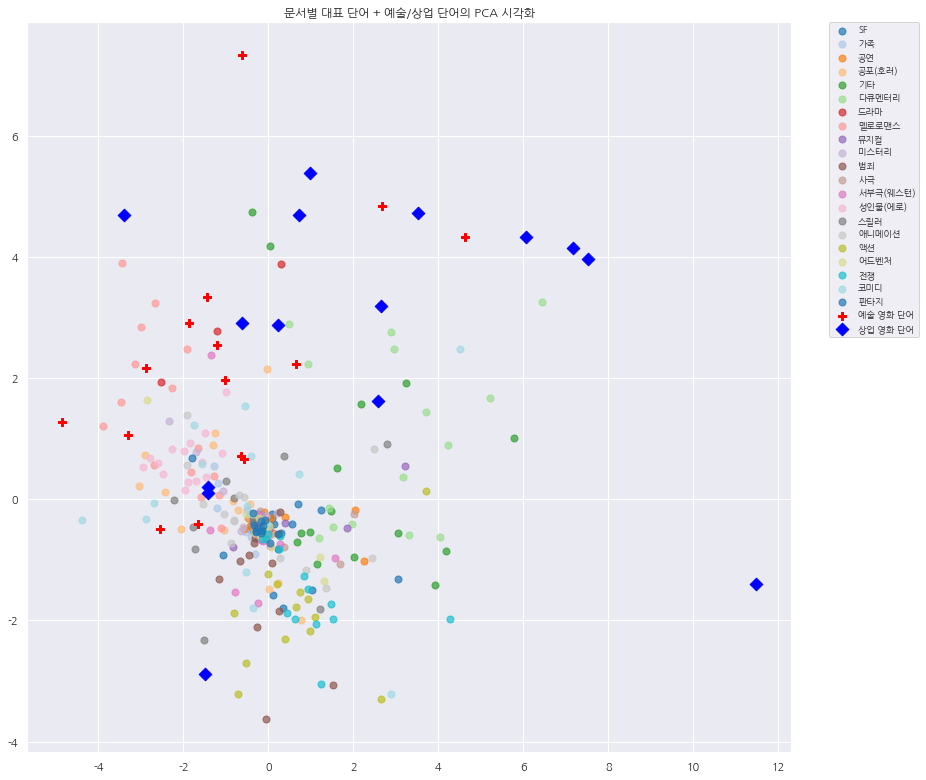

In [152]:
draw_pca(attributes_2)

중복 단어 제거 전보다 더 점들이 모여있다.

기존의 중복 단어들이 비슷한 위치의 다른 단어로 바뀌어 밀집도가 더 높아 보이는 것이라 생각한다.

### 3. LSA 기반 attribute

In [138]:
matrix_3 = weat_matrix(doc_keywords)

SF 가족 -0.7674697
SF 공연 -0.8247801
SF 공포(호러) -0.98660463
SF 기타 -0.60269964
SF 다큐멘터리 -0.6725646
SF 드라마 -0.08939563
SF 멜로로맨스 -0.89657545
SF 뮤지컬 -0.8581327
SF 미스터리 -1.0053028
SF 범죄 -0.8679935
SF 사극 -0.8045964
SF 서부극(웨스턴) -0.58301085
SF 성인물(에로) -0.5424319
SF 스릴러 -0.8267234
SF 애니메이션 -0.90551084
SF 액션 -0.7047911
SF 어드벤처 -0.8863187
SF 전쟁 -0.75751376
SF 코미디 -0.7474022
SF 판타지 -0.6961065
가족 공연 0.6457652
가족 공포(호러) -0.28713068
가족 기타 0.62121826
가족 다큐멘터리 0.32834545
가족 드라마 0.680532
가족 멜로로맨스 0.28068492
가족 뮤지컬 0.52211404
가족 미스터리 0.07077701
가족 범죄 -0.27501664
가족 사극 0.6424192
가족 서부극(웨스턴) 0.68131274
가족 성인물(에로) 0.5984679
가족 스릴러 0.2997382
가족 애니메이션 0.1836862
가족 액션 -0.09792292
가족 어드벤처 0.5023612
가족 전쟁 0.5632578
가족 코미디 -0.14772642
가족 판타지 0.7155614
공연 공포(호러) -0.85827476
공연 기타 0.15185048
공연 다큐멘터리 -0.40037805
공연 드라마 0.6472129
공연 멜로로맨스 -0.50396657
공연 뮤지컬 0.03073602
공연 미스터리 -0.7804855
공연 범죄 -0.69906175
공연 사극 -0.06623606
공연 서부극(웨스턴) 0.53787977
공연 성인물(에로) 0.0022742774
공연 스릴러 -0.5479801
공연 애니메이션 -0.5335228
공연 액션 -0.49708

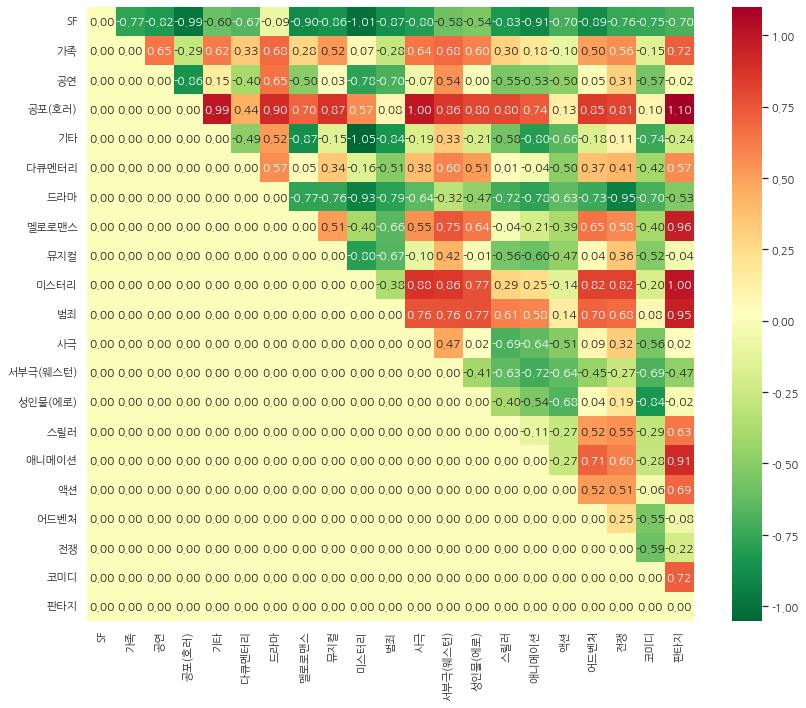

In [139]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 폰트 설정
sns.set(font='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 플롯 크기 설정
plt.figure(figsize=(12, 10))  # 원하는 크기로 조절 (가로, 세로)

# heatmap 그리기 (소수점 둘째 자리까지 표시)
ax = sns.heatmap(
    matrix_3,
    xticklabels=genre_name,
    yticklabels=genre_name,
    annot=True,
    fmt=".2f",  # 소수점 둘째 자리 반올림
    cmap='RdYlGn_r'
)

plt.tight_layout()
plt.show()

- SF와 드라마 장르의 경우 다른 장르에 비해 상업영화 쪽으로 치우친 것을 확인할 수 있다.
- 공포/호러와 미스터리, 범죄 장르가 다른 장르에 비해 예술영화 쪽으로 치우쳤다.
- 더 자세한 비교는 아래 결과에서 확인해보자.

In [140]:
print("=== WEAT 점수 | 절댓값 기준 0.8 이상만 출력 ===")
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        score = matrix_3[i][j]
        if abs(score) >= 0.8:
            print(f"{genre_name[i]} vs {genre_name[j]}: {score:.3f}")

=== WEAT 점수 | 절댓값 기준 0.8 이상만 출력 ===
SF vs 공연: -0.825
SF vs 공포(호러): -0.987
SF vs 멜로로맨스: -0.897
SF vs 뮤지컬: -0.858
SF vs 미스터리: -1.005
SF vs 범죄: -0.868
SF vs 사극: -0.805
SF vs 스릴러: -0.827
SF vs 애니메이션: -0.906
SF vs 어드벤처: -0.886
공연 vs 공포(호러): -0.858
공포(호러) vs 기타: 0.992
공포(호러) vs 드라마: 0.901
공포(호러) vs 뮤지컬: 0.875
공포(호러) vs 사극: 0.997
공포(호러) vs 서부극(웨스턴): 0.863
공포(호러) vs 성인물(에로): 0.805
공포(호러) vs 어드벤처: 0.847
공포(호러) vs 전쟁: 0.809
공포(호러) vs 판타지: 1.100
기타 vs 멜로로맨스: -0.868
기타 vs 미스터리: -1.052
기타 vs 범죄: -0.843
기타 vs 애니메이션: -0.802
드라마 vs 미스터리: -0.932
드라마 vs 전쟁: -0.947
멜로로맨스 vs 판타지: 0.961
미스터리 vs 사극: 0.881
미스터리 vs 서부극(웨스턴): 0.855
미스터리 vs 어드벤처: 0.821
미스터리 vs 전쟁: 0.816
미스터리 vs 판타지: 1.002
범죄 vs 판타지: 0.951
성인물(에로) vs 코미디: -0.838
애니메이션 vs 판타지: 0.913


- 위에서 확인했던 바와 같이 SF와 드라마가 상업성을 띄고, 공포와 미스터리가 예술성을 띄고 있다.
    - SF가 대부분 상업성을 띄는 것과 미스터리가 대부분 예술 영화임은 내 생각과 동일하다.
    - 드라마의 경우 인간 내면과 관계를 다루는 작품을 고려하면 상업성을 크게 띈다고 보기 어려울 것 같다.
    - 공포 영화의 경우에도 저예산 B급 또는 흥행 목표로 제작된 경우가 많아 예술성으로 치위는 것은 이해하기 어렵다.
- 기타의 경우 장르가 특정되지 않았기 때문에 상업성이나 예술성을 띄지 않을 것이라 판단되는데, 기타와의 비교에서 예술 영화 경향성이 높은 공포, 멜로로멘스, 미스터리, 범죄, 애니메이션 장르가 예술 영화의 경향을 띈다고 보여진다.
    - 애니메이션 장르의 경우 어린이 타깃 중심인 경우 상업영화로 간주하고, 예술영화가 꽤 있으나 기타 장르와의 비교에서 예술 영화로 치우치는 것은 이해하기 힘들다.
- 판타지 영화가 상업 영화로 인식되는 경향이 높다. 판타지와 같이 돈이 많이 필요한 영화가 예술영화로 나오는 경우는 잘 없다고 생각하여 일리가 있다고 판단된다.
- 다큐멘터리 장르가 예술영화와 매우 밀접한 관련이 있을 것으로 생각되었는데, TF-IDF 결과보단 중립에 가까워졌으나 왜 예술영화로 치우치지 않는지 의문이다.

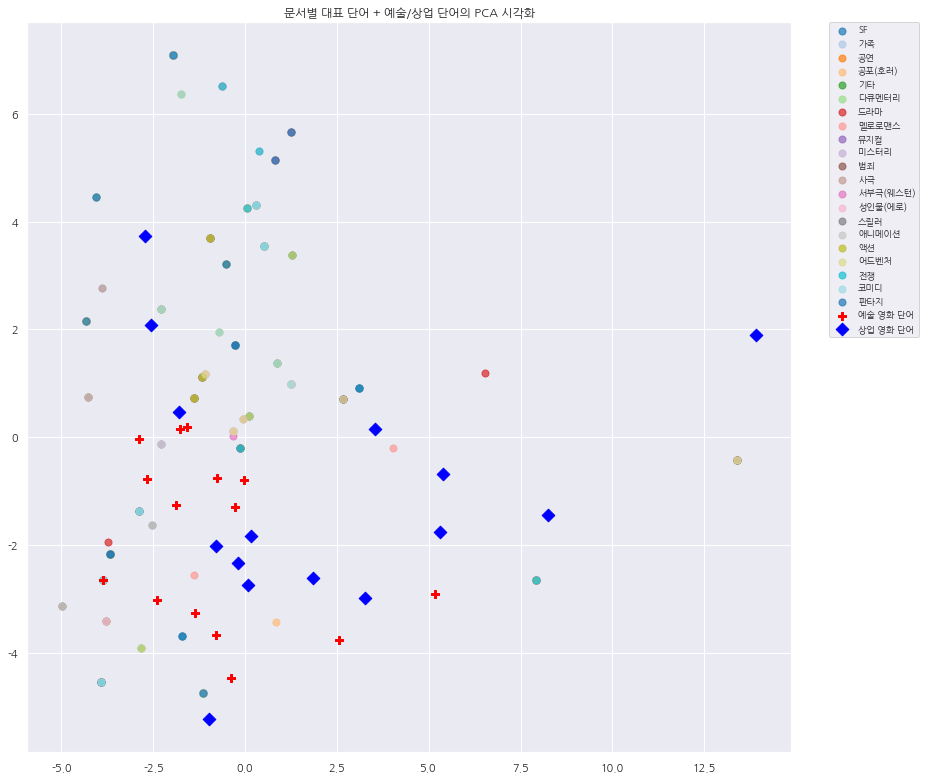

In [153]:
draw_pca(doc_keywords)

문서들이 공통된 토픽을 고른 경우 토픽의 순위에 따라 개수를 다르게 하여 차등 배분하였으나, 그래도 중복 단어가 꽤 많아 그래프가 빽빽하지 않다.

## 회고
- 어떤 방식으로 대표 단어를 찾아야 할 지 매우 막막한 프로젝트였다.
- 단어를 찾은 뒤 중복 단어를 제거하는 과정에서도 반복적으로 중복 단어를 모두 제가할 시 시간이 너무 오래 걸리거나 충분한 양의 단어를 뽑아내지 못하고, 결국 해당 문서와 관련이 적은 단어들로 대표 단어가 구성되는 문제가 발생하여 어느 정도까지 중복을 허용할 지 많이 고민했다.
- 이 프로젝트를 통해 학습 데이터에 따라 인간의 편향이 모델에 학습되는 것을 확인할 수 있었고, 이후 인공지능 학습 단계에서 사용하는 데이터의 편향을 고려해야겠다고 생각하였다.